# User View

This notebook demonstrates how a **workspace user** can access the workspaces they have been granted access to and explore related details such as required credentials, management pages, and available collaboration tools.

Within the workspace, the user can:
- Invite additional members,
- Create new buckets for sharing data or for temporary scratch storage,
- Manage access to their own buckets (granting or revoking permissions),
- Request access to other shared buckets,
- And directly open the associated **Datalab** environment.

To perform these actions, the workspace user must be properly **authenticated** with the corresponding workspace **access permissions** — specifically, the `ws_access` role assigned to the dynamically created workspace client (which shares the same name as the workspace).

These authorization mechanisms are governed by the **EOEPCA IAM** model, implemented through **APISIX** with the **OpenID Connect plugin** and **Open Policy Agent (OPA)** to enable fine-grained access control.


In [8]:
# Imports
import jwt
import requests
import time
import os
from dotenv import load_dotenv
import urllib3

urllib3.disable_warnings()
load_dotenv()

True

In [9]:
# Config
realm = os.getenv("REALM")
base_domain = os.getenv("BASE_DOMAIN")
keycloak_endpoint = os.getenv("KEYCLOAK_ENDPOINT")
default_scope = os.getenv("DEFAULT_SCOPE")
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

issuer = f"{keycloak_endpoint}/realms/{realm}"
token_endpoint = f"{issuer}/protocol/openid-connect/token"
device_authorization_endpoint = f"{issuer}/protocol/openid-connect/auth/device"
userinfo_endpoint = f"{issuer}/protocol/openid-connect/userinfo"

workspace_api_endpoint = f'https://workspace-api.{base_domain}/workspaces'

In [10]:
# Helper function to get token via device flow
def token_via_device_flow(
    client_id: str,
    client_secret: str | None = None,
    scope: str = "openid profile email",
    poll_interval: int | None = None,
    timeout: int = 600
):
    da_resp = requests.post(
        device_authorization_endpoint,
        headers={"Content-Type": "application/x-www-form-urlencoded"},
        data={
            "client_id": client_id,
            **({"client_secret": client_secret} if client_secret else {}),
            "scope": scope,
        },
        timeout=30,
    )
    da_resp.raise_for_status()
    da = da_resp.json()

    device_code = da["device_code"]
    user_code = da["user_code"]
    verification_uri = da["verification_uri"]
    verification_uri_complete = da.get("verification_uri_complete")
    interval = poll_interval or da.get("interval", 5)
    expires_in = da.get("expires_in", timeout)

    print(f"Open: {verification_uri}")
    print(f"Enter code: {user_code}")
    if verification_uri_complete:
        print(f"(Or open directly): {verification_uri_complete}")

    start = time.time()
    data = {
        "grant_type": "urn:ietf:params:oauth:grant-type:device_code",
        "device_code": device_code,
        "client_id": client_id,
        **({"client_secret": client_secret} if client_secret else {}),
    }
    headers = {"Content-Type": "application/x-www-form-urlencoded"}

    while True:
        if time.time() - start > min(timeout, expires_in):
            raise TimeoutError("Device authorization timed out.")
        resp = requests.post(token_endpoint, headers=headers, data=data, timeout=30)
        if resp.ok:
            tok = resp.json()
            break
        try:
            err = resp.json().get("error")
        except Exception:
            resp.raise_for_status()
        if err == "authorization_pending":
            time.sleep(interval)
            continue
        elif err == "slow_down":
            interval += 5
            time.sleep(interval)
            continue
        elif err in ("access_denied", "expired_token", "invalid_grant"):
            raise RuntimeError(f"Device flow failed: {err}")
        else:
            resp.raise_for_status()

    access_token = tok.get("access_token")
    decoded = jwt.decode(access_token, options={"verify_signature": False, "verify_aud": False})

    print("\n--- Decoded Access Token ---")
    for k, v in decoded.items():
        print(f"{k}: {v}")

    ra = decoded.get("resource_access", {}) or {}
    roles_wsapi = ra.get(client_id, {}).get("roles", []) or []
    is_operator = "admin" in roles_wsapi

    workspaces = []
    for client, meta in ra.items():
        roles = (meta or {}).get("roles", []) or []
        if client.startswith("ws-") and "ws_access" in roles:
            workspaces.append(client)

    print("\n--- Access Summary ---")
    if is_operator:
        print("user is OPERATOR")
    elif workspaces:
        print(f"user has WORKSPACE ACCESS: {', '.join(sorted(workspaces))}")
    else:
        print("user is neither OPERATOR nor has WORKSPACE ACCESS")

    return access_token, is_operator, sorted(workspaces)


In [11]:
# Retrieve token via device flow
token, is_operator, workspaces = token_via_device_flow(client_id=client_id, client_secret=client_secret)

Open: https://iam-auth.develop.eoepca.org/realms/eoepca/device
Enter code: NQSR-SUUF
(Or open directly): https://iam-auth.develop.eoepca.org/realms/eoepca/device?user_code=NQSR-SUUF

--- Decoded Access Token ---
exp: 1760723373
iat: 1760723073
auth_time: 1760722943
jti: dbebe852-d3e9-4c2b-a0fc-7d8761083157
iss: https://iam-auth.develop.eoepca.org/realms/eoepca
aud: ['ws-alice', 'account']
sub: 5865cc63-abc6-4bf9-97d4-2d9ba7deec4c
typ: Bearer
azp: workspace-api
sid: 67d7e9d1-7902-4f86-928c-a82f30cd56ab
acr: 0
allowed-origins: ['/*']
realm_access: {'roles': ['offline_access', 'default-roles-eoepca', 'uma_authorization']}
resource_access: {'ws-alice': {'roles': ['ws_access']}, 'account': {'roles': ['manage-account', 'view-consent', 'manage-account-links', 'manage-consent', 'view-profile']}}
scope: openid profile email
email_verified: True
name: Alice A
groups: ['/ws-alice']
preferred_username: alice
given_name: Alice
family_name: A
email: alice@eoepca.org

--- Access Summary ---
user has 

In [12]:
# Helper function to take screenshot using playwright
from playwright.async_api import async_playwright
from IPython.display import Image, display

async def snap_with_bearer_full(url: str, access_token: str, widen=True, fix_scroll=False):
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        ctx = await browser.new_context(
            extra_http_headers={"Authorization": f"Bearer {access_token}"},
            viewport={"width": 1920, "height": 1080} if widen else None,
            device_scale_factor=2  # crisp
        )
        page = await ctx.new_page()
        await page.goto(url, wait_until="networkidle")

        if fix_scroll:
            await page.add_style_tag(content="""
                html, body { height: auto !important; }
                [style*="overflow"], .scroll, .scrollable, .overflow-auto, .overflow-y-auto {
                    overflow: visible !important; max-height: none !important; height: auto !important;
                }
            """)

        img = await page.screenshot(full_page=True)  # entire page height
        await browser.close()
        display(Image(data=img))

In [13]:
ws_name = "ws-alice" # exists on eopeca-demo environment
assert ws_name in workspaces, f"User does not have access to workspace {ws_name}"

In [14]:
# Check workspace creation status via API
headers = {
    'Authorization': 'bearer ' + token
}
url = f"{workspace_api_endpoint}/{ws_name}"
print(f"HTTP GET {url}")
response = requests.get(url, headers=headers)
assert response.status_code == 200

HTTP GET https://workspace-api.develop.eoepca.org/workspaces/ws-alice


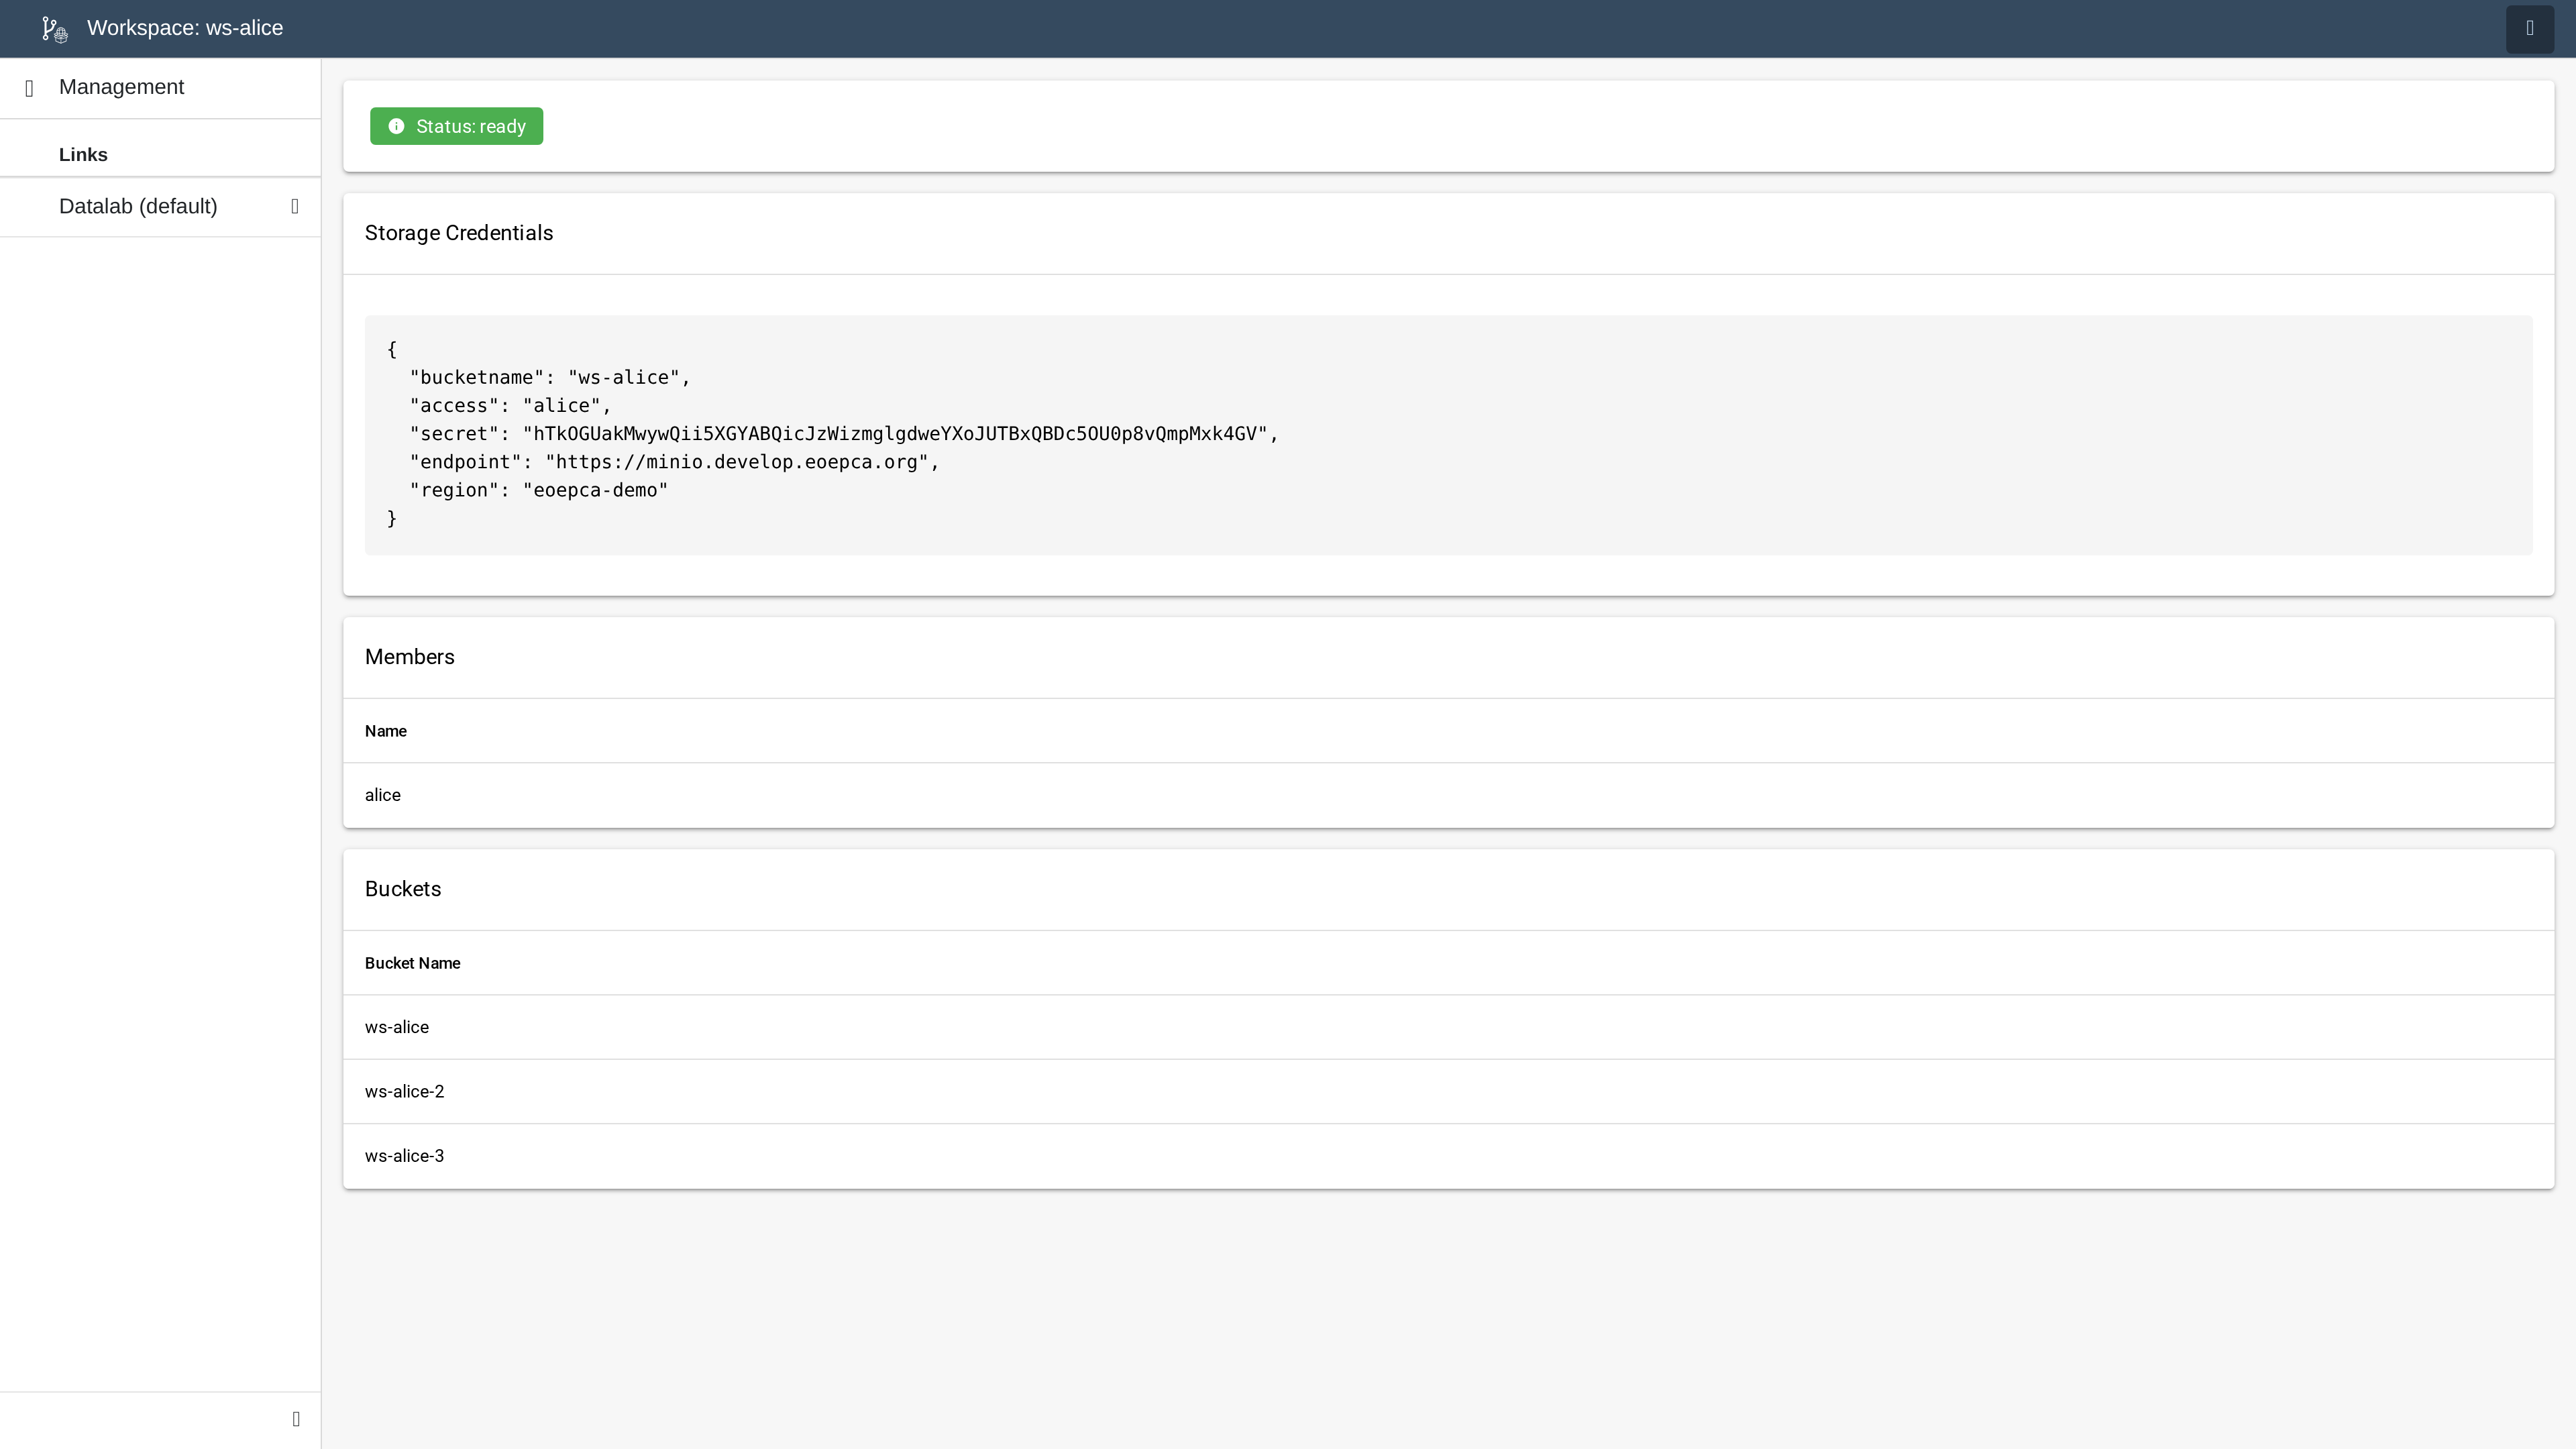

In [15]:
# Dashboard screen
await snap_with_bearer_full(url, token)

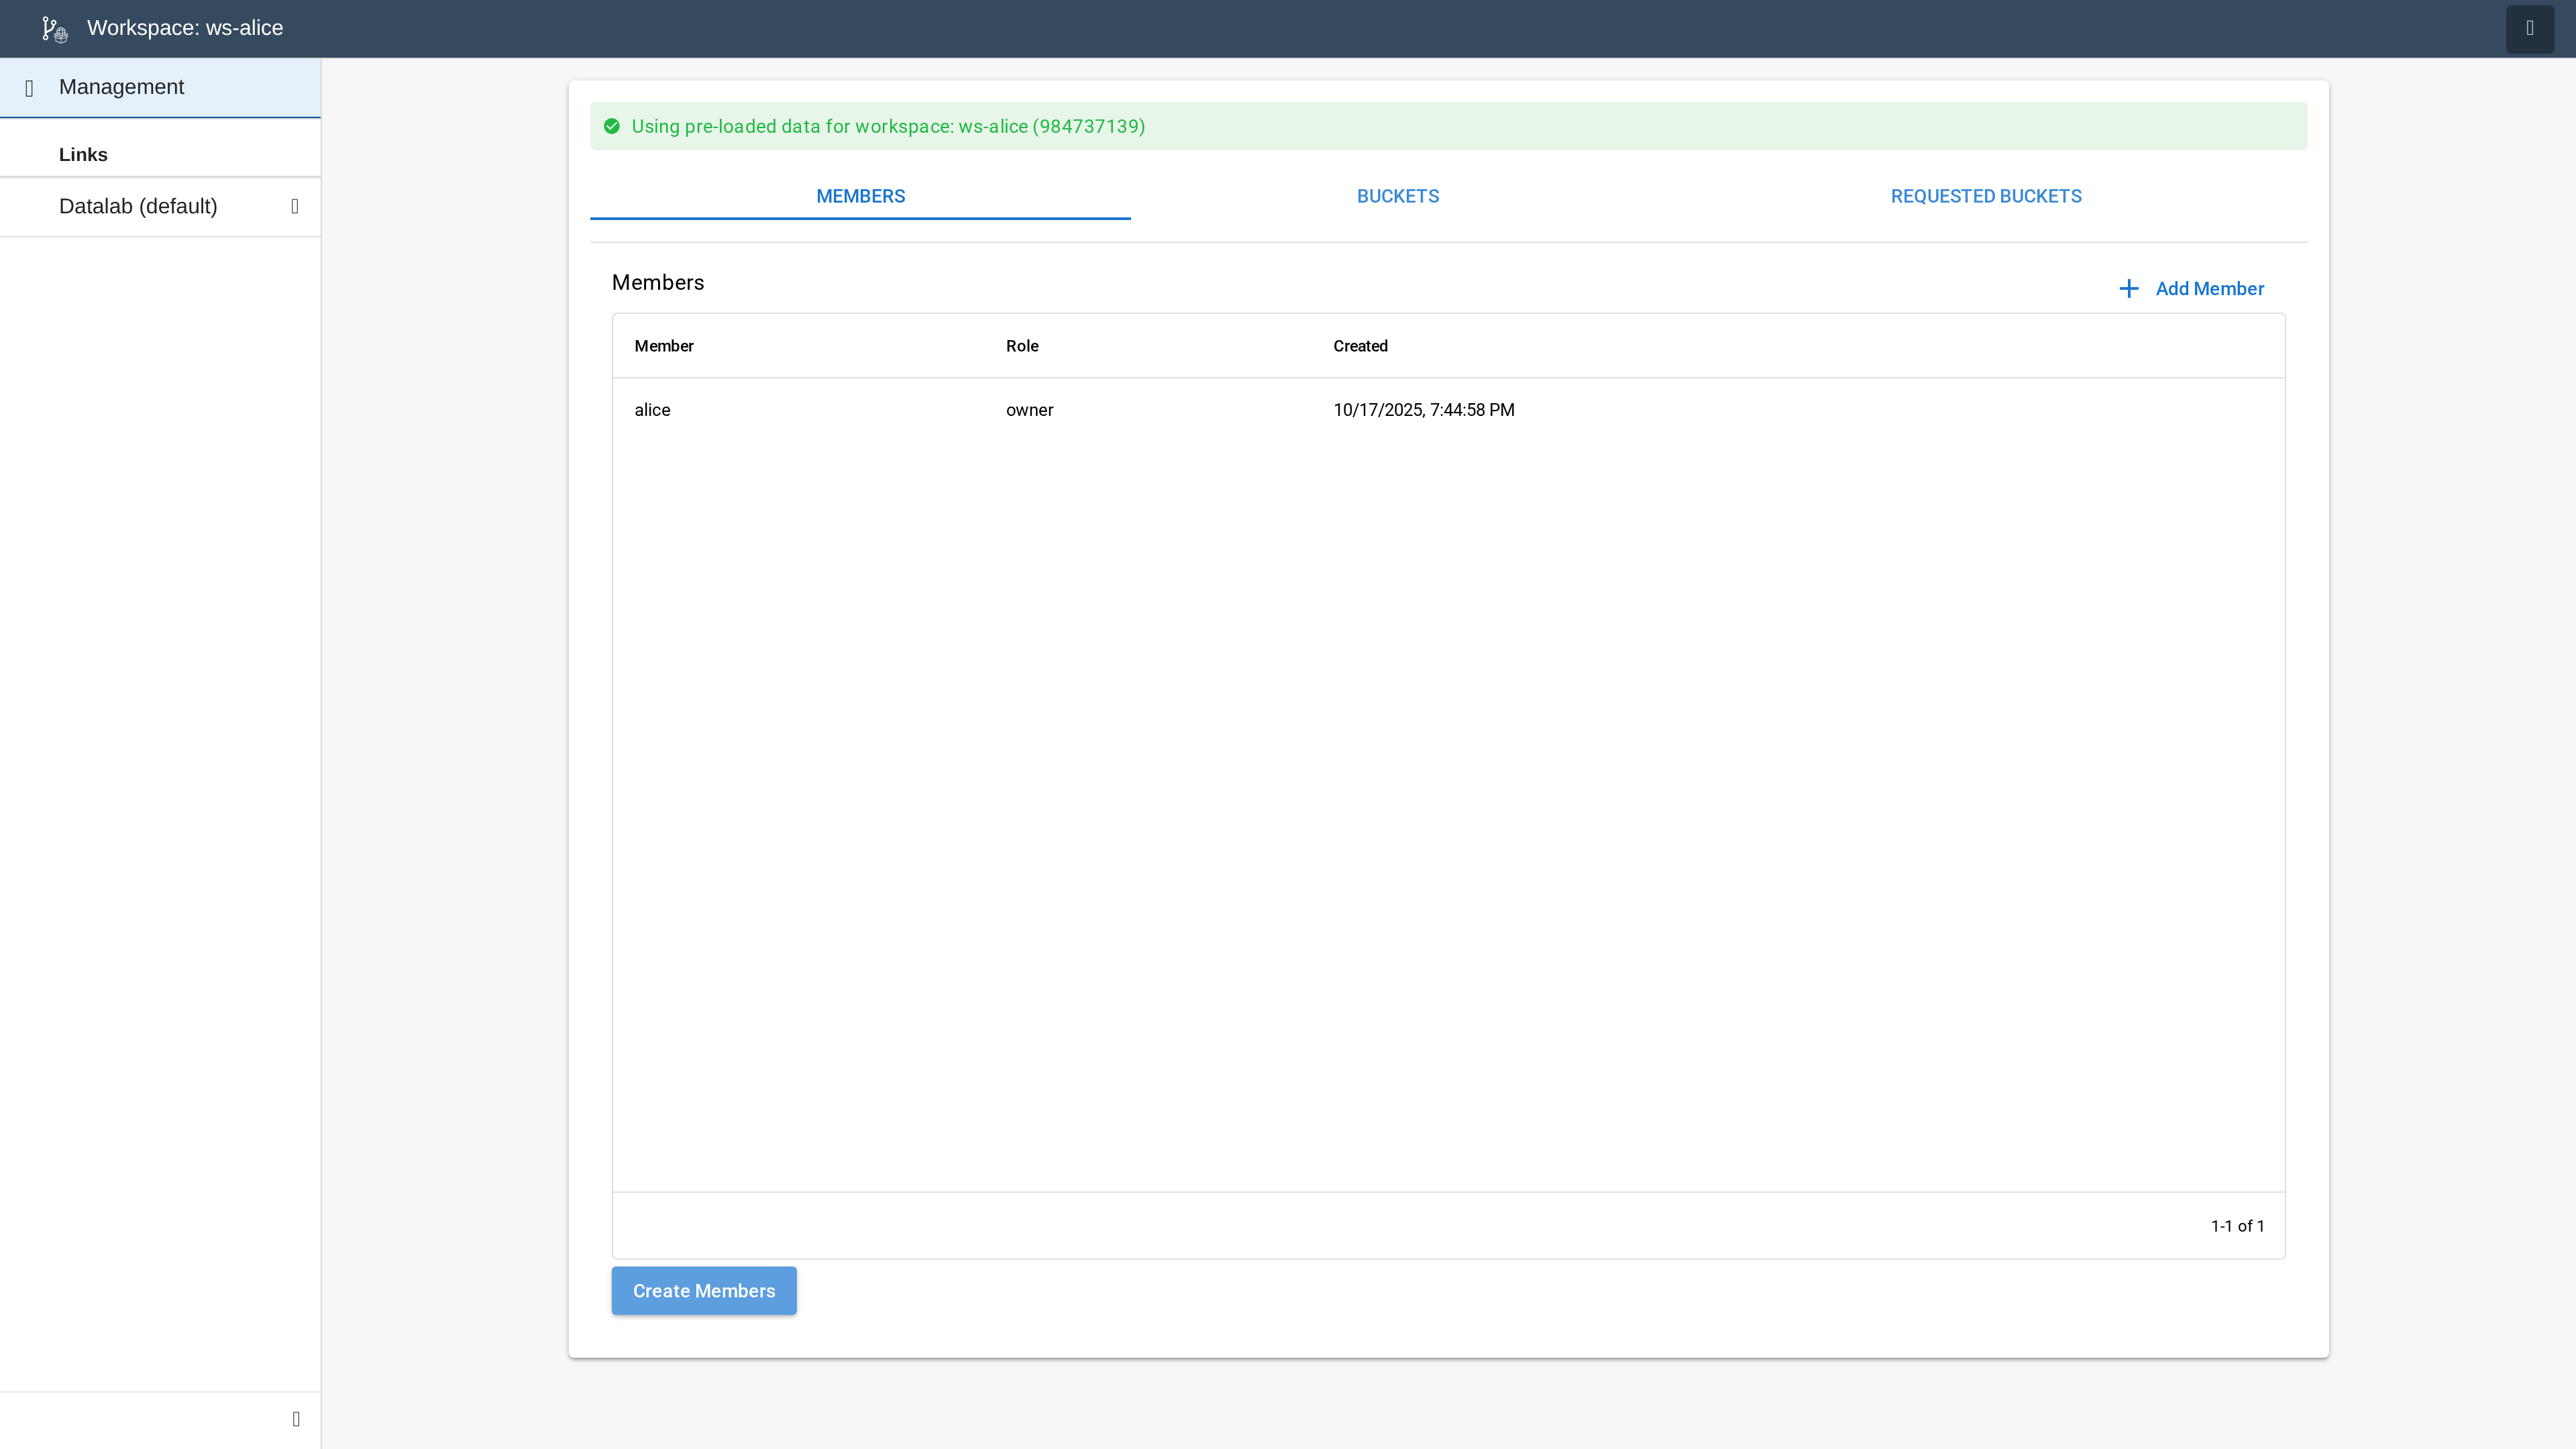

In [16]:
# Management screen
await snap_with_bearer_full(f"{url}#/home/management", token)

In [ ]:
# Datalab screen (default session)
await snap_with_bearer_full(f"{url}/sessions/default", token)